# OSZTYN

### Scraping out information from home pages

In [ ]:
# vars
url = 'https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/warminsko--mazurskie/olsztyn/olsztyn/olsztyn'
url_n = 'https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/warminsko--mazurskie/olsztyn/olsztyn/olsztyn?page='
all_df = pd.DataFrame()
city = 'olsztyn'

In [1]:
import os

# prepering directories
path = os.getcwd()
# subfolders
input_dir = os.path.join(path, 'inputs')
output_dir = os.path.join(path, 'outputs')

In [1]:
# selenium 
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# BeautifulSoup
from bs4 import BeautifulSoup

import datetime
import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()


Bad key "text.kerning_factor" on line 4 in
C:\Users\Ukasz\Anaconda3\envs\geopandas\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
# chrome driver location
PATH = os.path.join(path, 'inputs','chromedriver.exe' )

# chrom driver configuration
options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
options.add_argument('--incognito')
#options.add_argument('--headless') # without opening browser

driver = webdriver.Chrome(PATH, options=options)

wait = WebDriverWait(driver, 10)

In [5]:
# get number of pages

# open website using webdriver
driver.get(url)
print(f"Opens website: {url}")

# accepting terms and conditions
# step One - pokaz cele
element = wait.until(EC.element_to_be_clickable((By.ID, 'onetrust-pc-btn-handler')))
element.click()
# step two -  confirming preferences and closing the modal window
element = wait.until(EC.element_to_be_clickable((By.XPATH, "//*[contains(text(), 'Potwierdzenie moich wyborów')]")))
element.click()

# step - get number of the paginations
## using SOUP
soup = BeautifulSoup(driver.page_source, 'html.parser')
# save homepage to the file & soup
date = datetime.datetime.now().strftime("%Y%m%d") # current date
    
# finds nav with paginations 
# scrapped HTML code can be displayed and pretty printed in Notepad++ using the plugin XML tools
target = soup.find('nav', attrs={'aria-label':'Nawigacja po paginacji'})
date = datetime.datetime.now().strftime("%Y%m%d") # current date
with open(os.path.join(path, 'outputs', 'nav_pagination' + date + '.html'), "w", encoding='utf-8') as file:
    file.write(str(target))
    
# selects all hyperlinks from the nav section
hrefs = target.find_all("a")
# get the hyperlink with the highest number which represents number of pages with adds for the given city
pagination_last = 1
for a in hrefs:
    try:
        num = int(a.get_text())
        pagination_last =  num if pagination_last < num else pagination_last
    except:
        pass
print(f'Number of pages: {pagination_last}')

Opens website: https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/warminsko--mazurskie/olsztyn/olsztyn/olsztyn
Number of pages: 21


In [34]:
def scrap_page(url):
    '''
    - returns a soup section of a given page containing adds
    '''
    driver.get(url)
    time.sleep(2) # waits n seconds
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;")
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    return soup.find('div', attrs={'data-cy':'search.listing.organic'})
    
def has_article(tag):
    '''
    - info about adds is kept in <li> that contain <artcicle> tag
    '''
    return tag.name == 'li' and tag.find('article') is not None

def get_adds(data):
    '''
    - info about adds is kept in <li> that contain <article> tag
    '''
    return data.find_all(has_article)

def soup_to_dataframe(data):
    '''
    - gets soup and returns dataframe
    '''
    adds = []
    for add in data:
        artcile = add.find('article')
        # gets any tags with the attribute 'title'
        titles = artcile.find_all(lambda tag: tag is not None and tag.has_attr("title"))
        price = price_meter = rooms = area = more = None

        info = add.find_all('span')
        for e in info:
            e = e.text
            if '\xa0zł' in e and 'zł/m²' not in e:
                price = e
            if 'zł/m²' in e:
                price_meter = e
            if [element for element in ['pokoje','pokoi','pokój'] if(element in e)]:
                rooms = e
            if 'm²' in e and 'zł/m²' not in e:
                area = e
        more = info[-1].text

        adds.append({
            'free_text': titles[0]['title'],
            'address': titles[1]['title'],
            'price': price,
            'price_meter': price_meter,
            'rooms': rooms,
            'area': area,
            'more':more,
            'add_link': add.select_one('a')['href']
        })
    # Creates DataFrame.
    df = pd.DataFrame(adds)
    
    return df

for n in range(pagination_last):
    n = n + 1
    data = scrap_page(url_n + str(n))
    data = get_adds(data)
    df = soup_to_dataframe(data)
    df.to_csv(os.path.join(output_dir, f'{city}_page_{str(n)}.csv'), encoding='utf-8', index=False)
    # merges datframes
    all_df = pd.concat([all_df, df])
    all_df = all_df.reset_index(drop=True)
    date = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

all_df.to_csv(os.path.join(output_dir, f'{city}_page_all_pages_{date}.csv'), encoding='utf-8', index=False)
    
    

### BASIC STATS

In [6]:
# OPENS FILE EXPLORER OF THE GIVEN DIRECTORY
import subprocess
subprocess.Popen(f'explorer "{output_dir}"')

In [4]:
data = pd.read_csv(os.path.join(os.getcwd(), 'outputs', 'olsztyn_page_all_pages_20240106151418.csv'))

In [5]:
data.shape

(749, 8)

In [6]:
data.head(2)

,free_text,address,price,price_meter,rooms,area,more,add_link
0,Apartament Premium nad jeziorem Olsztyn Mazury,"Mieszkanie na sprzedaż: Olimpijska 21, Likusy,...",459 000 zł,16 393 zł/m²,2 pokoje,28 m²,28 m²,/pl/oferta/apartament-premium-nad-jeziorem-ols...
1,Przestronne 3pokojowe mieszkanie w Centrum Jarot!,Mieszkanie na sprzedaż: ul. Floriana Piotrowsk...,630 000 zł,9251 zł/m²,3 pokoje,"68,1 m²",Biuro nieruchomości,/pl/oferta/przestronne-3pokojowe-mieszkanie-w-...


#### Cleaning the 'price' column

In [7]:
data['price'] = data['price'].str.replace(u'\xa0', u' ')
data['price'] = data['price'].str.replace(' ', '', regex=True)
data['price'] = data['price'].str.replace('zł', '', regex=True)
data['price'] = data['price'].str.replace(',', '.', regex=True)
# drop nan
data = data[data['price'].notna()]
data['price'] = pd.to_numeric(data['price'])

#### Cleaning the 'price_meter' column

In [8]:
data['price_meter'] = data['price_meter'].str.replace(u'\xa0', u' ')
data['price_meter'] = data['price_meter'].str.replace(' ', '', regex=True)
data['price_meter'] = data['price_meter'].str.replace('zł/m²', '', regex=True)
data['price_meter'] = data['price_meter'].str.replace(',', '.', regex=True)
# drop nan
data = data[data['price_meter'].notna()]
data['price_meter'] = pd.to_numeric(data['price_meter'])

#### Cleaning the 'area' column

In [9]:
data['area'] = data['area'].str.replace(u'\xa0', u' ')
data['area'] = data['area'].str.replace(' ', '', regex=True)
data['area'] = data['area'].str.replace('m²', '', regex=True)
data['area'] = data['area'].str.replace(',', '.', regex=True)
# drop nan
data = data[data['area'].notna()]
data['area'] = pd.to_numeric(data['area'])

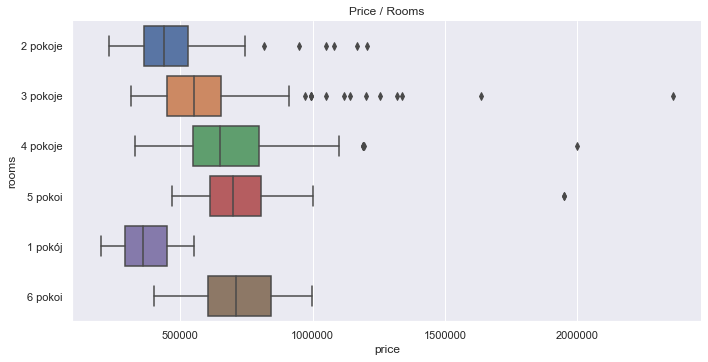

In [58]:

sns.catplot(data=data, x="price", y="rooms", kind="box", height=5, aspect=2)
plt.title('Price / Rooms')
plt.show()

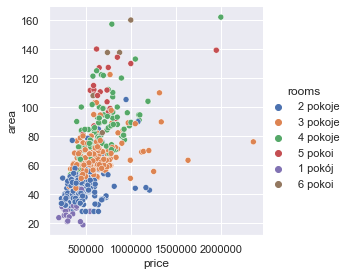

In [65]:
tips = sns.load_dataset("tips")
sns.relplot(data=data, x="price", y="area", height=4, hue="rooms")

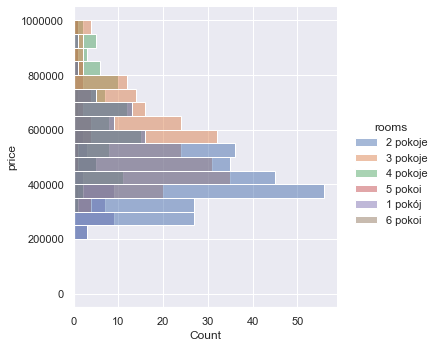

In [71]:
sns.displot(data, y="price", bins=list(range(0,1050000, 50000 )), hue='rooms')


In [76]:
data.describe().astype(int)

,price,price_meter,area
count,684,684,684
mean,549150,9755,59
std,226630,3428,23
min,200000,4421,18
25%,402250,7544,42
50%,501983,8900,56
75%,640000,11145,70
max,2360000,31053,162


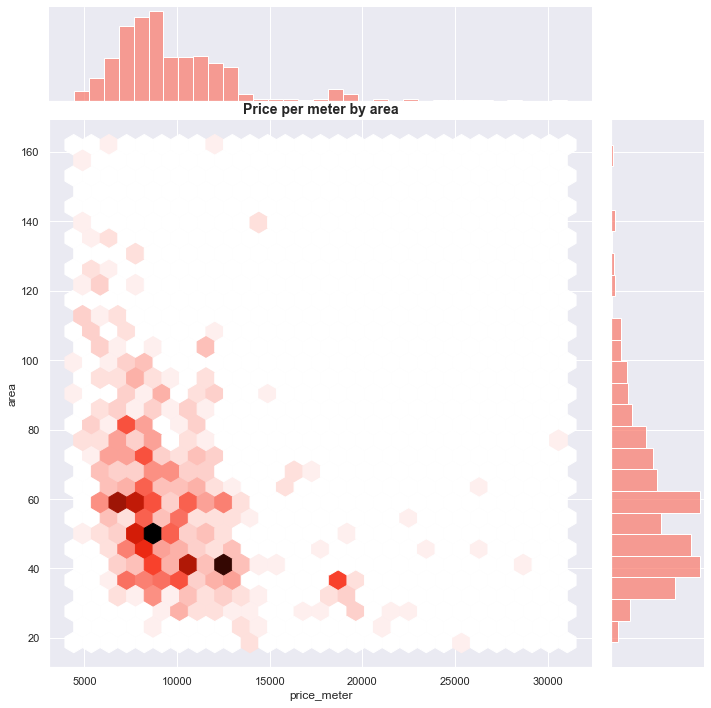

In [79]:
sns.jointplot(data=data, x="price_meter", y="area", kind="hex", color='#fa8072', height = 10)
plt.title('Price per meter by area', fontsize=14, fontweight='bold');

In [80]:
data['rooms_number'] = data['rooms'].str.extract('(\d+)').astype(int)

In [81]:
data.describe().astype(int)

,price,price_meter,area,rooms_number
count,684,684,684,684
mean,549150,9755,59,2
std,226630,3428,23,0
min,200000,4421,18,1
25%,402250,7544,42,2
50%,501983,8900,56,3
75%,640000,11145,70,3
max,2360000,31053,162,6


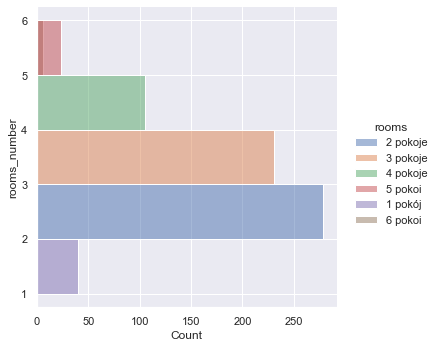

In [83]:
sns.displot(data, y="rooms_number", bins=list(range(1,max(data['rooms_number'] + 1), 1 )), hue='rooms')

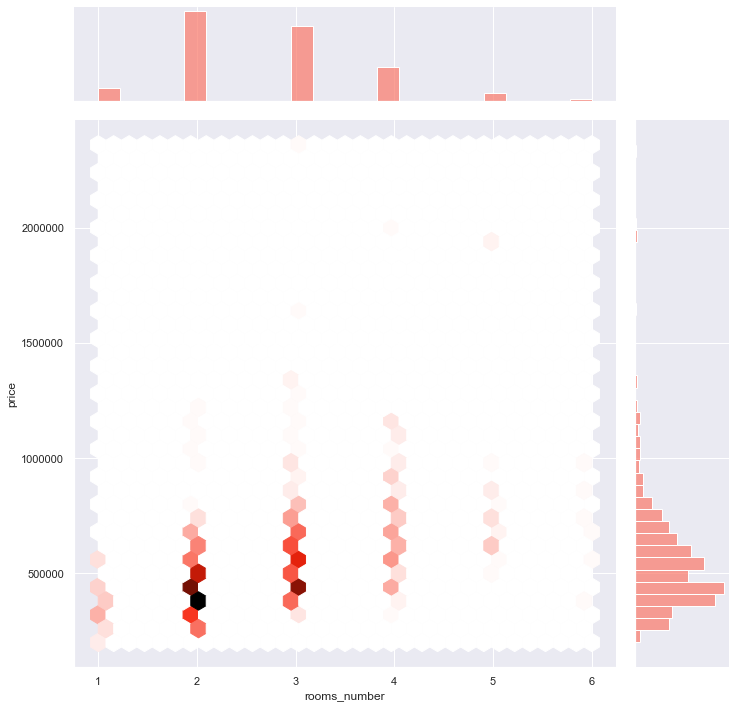

In [88]:
sns.jointplot(data=data, x="rooms_number", y="price", kind="hex", color='#fa8072', height = 10)

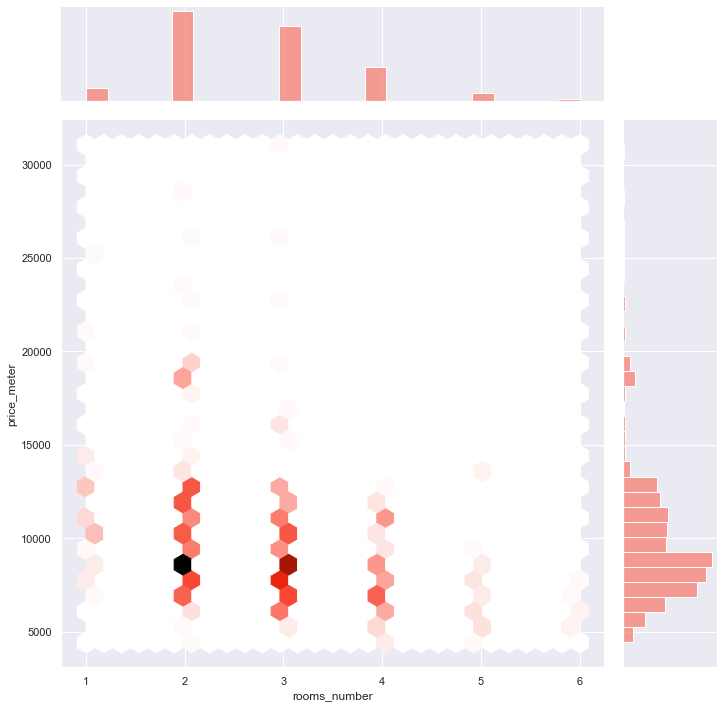

In [89]:
sns.jointplot(data=data, x="rooms_number", y="price_meter", kind="hex", color='#fa8072', height = 10)

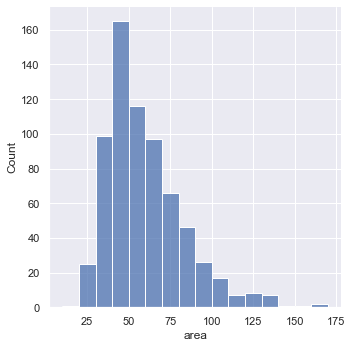

In [94]:
sns.displot(data, x="area", bins=list(range(10,int(max(data['area'])) + 10, 10)))